# Modelling a river in a cross-section

This notebook shows how to model a river with tidal fluctuations, based on an example from an old program called WATEX, which was used to derive the head beneath levee structures for input into geotechnical stability calculations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim

ttim.show_versions()

TTim version       : 0.7.0

Python version     : 3.12.3
Numpy version      : 2.1.3
Numba version      : 0.61.0
Scipy version      : 1.15.1
Pandas version     : 2.2.3
Matplotlib version : 3.10.0
LmFit version      : 1.3.2


## System description

The system we want to model is shown below. It consists of 4 sections:

1. River: the summer bed of the river cuts deeper into the subsurface than the other sections
2. Foreland: the winter bed of the river due to higher water levels
3. Hinterland: the polder area protected by a dike or levee
4. Far hinterland: same as hinterland, but optionally with different parameters.

![River Cross-Section](data/watex_cross_section.png)



## Aquifer properties and parameters

We will define some aquifer properties and parameters for each of the sections based on subsurface data. Note that we're modeling the hinterland and far-hinterland as one section in this example.

In a subsequent step the geohydrological parameters will be calibrated. 

In [2]:
# cross-sections
L_river = 75.00  # m, width river, though it extends to -infinity
L_foreland = 28.00  # m, width foreland
L_hinterland = 4000.00  # m, width hinterland, extends to +infinity

x0 = -(L_river + L_foreland)  # set x=0 at river bank

# layer elevations
ztop_riverbed = 1.00  # surface level in riverbed
ztop_foreland = 8.0  # surface level in foreland
ztop_hinterland = 8.0  # surface level in hinterland
ztop_aquifer = 0.0  # top of aquifer
zbot = -30.0  # bottom of aquifer

# geohydrology
kh = 10.0  # m/d, hydraulic conductivity
Saq = 1e-4  # 1/m, specific storage

Sll_river = 1e-6  # 1/m, specific storage aquitard
Sll_hinterland = 1e-3  # 1/m, specific storage aquitard

c_river = 100.0  # d, resistance riverbed
c_foreland = 150.0  # d, resistance foreland
c_hinterland = 500.0  # d, resistance hinterland

In [3]:
# set z-arrays for model
z_river = [ztop_riverbed, ztop_aquifer, zbot]
z_foreland = [ztop_foreland, ztop_aquifer, zbot]
z_hinterland = [ztop_hinterland, ztop_aquifer, zbot]

## Load river levels

Load data from csv file containing observed water levels relative to the mean observed water level for an 8-day period. The file contains the river stage and measurements from 2 piezometers next to the river. The water level at the polder is set to a constant value of 0.0 (i.e. no changes caused by river stage fluctuations).

In [4]:
data = pd.read_csv("data/watex_example.csv", index_col=[0])
data.head()

,rivier,kruin,binnenteen,polder
T [days],,,,
0.000000,0.000,0.000,0.000,0
0.020833,0.150,0.173,0.091,0
0.041667,0.160,0.177,0.091,0
0.062500,0.187,0.182,0.089,0
0.083333,0.197,0.185,0.085,0


<Axes: xlabel='T [days]'>

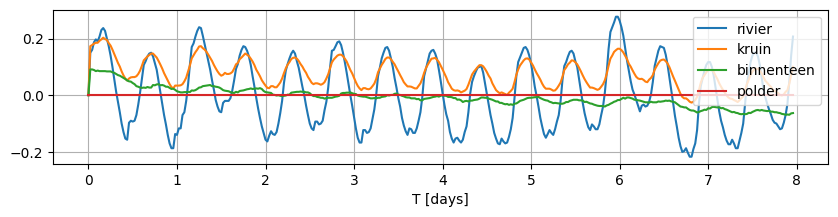

In [5]:
data.plot(figsize=(10, 2), grid=True)

Note that the observed fluctuations do not fluctuate around 0 for each of these locations. In order to model this system with TTim, we need the variation to be around 0.0, therefore, we normalize each time series by subtracting the mean. 

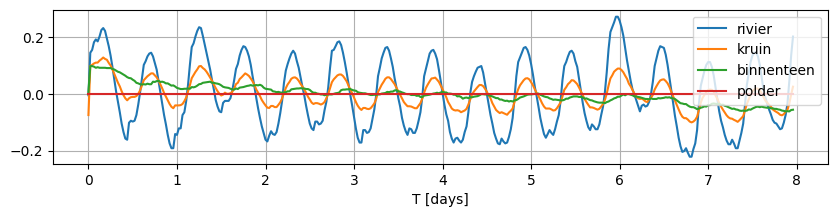

In [6]:
data_norm = data - data.mean()
data_norm.plot(figsize=(10, 2), grid=True);

## Build the cross-section model

Now we can build the cross-section model. 

First, we need to define the river levels for the top boundary condition in the river and foreland sections. We want a list of time waterlevel pairs for the river water level. 

We're dealing with a river under the influence of tides, which means we have to be careful when specifying the river level. TTim maintains a given water level from a specific time until the next specified water level. 

The following plot shows how TTim inteprets the water level for different pre-processing steps on the input data. If we just pass in the river time series as is, we're continually leading the observed water level (orange line). We want to make sure the TTim input meets the observed level about at the midpoint (black line) of each time interval.

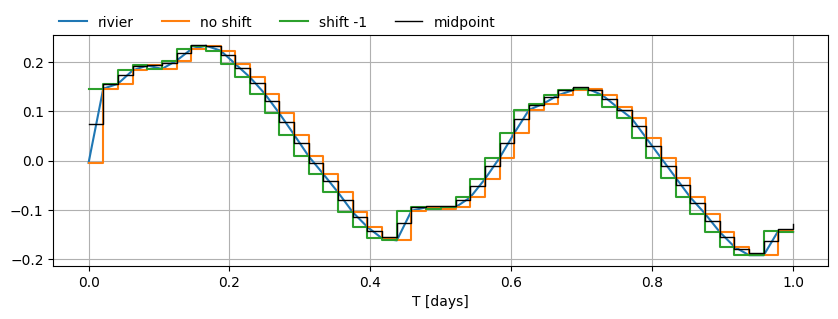

In [7]:
data_norm.loc[:1, "rivier"].plot(figsize=(10, 3), grid=True)
plt.step(
    data_norm.loc[:1].index,
    data_norm.loc[:1, "rivier"],
    where="post",
    label="no shift",
)
plt.step(
    data_norm.loc[:1].index,
    data_norm.loc[:1, "rivier"].shift(-1),
    where="post",
    label="shift -1",
)
mid = (data.loc[:, "rivier"] + data.loc[:, "rivier"].shift(-1).values).divide(2)
plt.step(
    mid.loc[:1].index, mid.loc[:1], where="post", label="midpoint", color="k", lw=1.0
)
plt.legend(loc=(0, 1), frameon=False, ncol=4);

In [8]:
# tsandhstar = data_norm["rivier"].to_frame().to_records().tolist()  # original
tsandhstar = mid.dropna().to_frame().to_records().tolist()  # midpoint
# tsandhstar = (
#     data_norm["rivier"].shift(-1).dropna().to_frame().to_records().tolist()
# )  # shift-1

In [9]:
ml = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)

river = ttim.XsectionMaq(
    ml,
    -np.inf,  # river extends to infinitiy
    x0 + L_river,
    z=z_river,
    kaq=kh,
    Saq=Saq,
    Sll=Sll_river,
    c=c_river,
    topboundary="semi",
    tsandhstar=tsandhstar,
    name="river",
)
foreland = ttim.XsectionMaq(
    ml,
    x0 + L_river,
    x0 + L_river + L_foreland,
    kaq=kh,
    z=z_foreland,
    Saq=Saq,
    Sll=Sll_river,
    c=c_foreland,
    topboundary="semi",
    tsandhstar=tsandhstar,
    name="foreland",
)
hinterland = ttim.XsectionMaq(
    ml,
    x0 + L_river + L_foreland,
    np.inf,  # hinterland extends to infinity
    kaq=kh,
    z=z_hinterland,
    Saq=Saq,
    Sll=Sll_hinterland,
    c=c_hinterland,
    topboundary="semi",
    name="hinterland",
)

ml.solve()

self.neq  4
solution complete


Check the sections

In [10]:
river, foreland, hinterland

(river: XsectionMaq [-inf, -28.0] with h*(t),
 foreland: XsectionMaq [-28.0, 0.0] with h*(t),
 hinterland: XsectionMaq [0.0, inf])

Plot a cross-section of the model. Note the water level is just schematic in this picture.

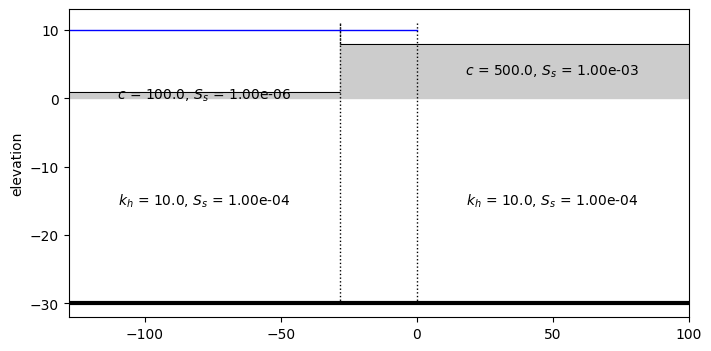

In [11]:
ax = river.plot(labels=False, params=True)
foreland.plot(ax=ax)
hinterland.plot(ax=ax, params=True)
ml.elementlist[0].plot(ax=ax, hstar=10)  # hstar element river
ml.elementlist[1].plot(ax=ax, hstar=10)  # hstar element foreland
ax.set_xlim(x0 - 25, 100.0);

Show the summary of aquifer parameters for each section:

In [12]:
ml.aquifer_summary()

layer   layer_type   k_h      c       S_s
           #                                          
river      0     0  leaky layer   NaN  100.0  0.000001
           1     0      aquifer  10.0    NaN    0.0001
foreland   0     0  leaky layer   NaN  150.0  0.000001
           1     0      aquifer  10.0    NaN    0.0001
hinterland 0     0  leaky layer   NaN  500.0     0.001
           1     0      aquifer  10.0    NaN    0.0001

Plot head over time at several x-locations.

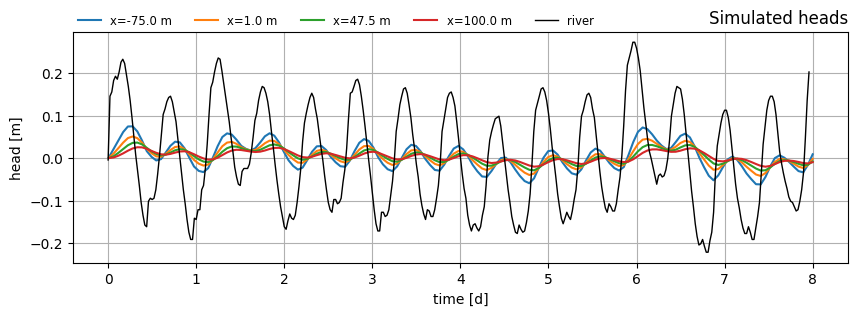

In [13]:
t = np.linspace(0.01, 8, 150)
xlocs = [
    -75.0,  # in river section
    1.0,  # at observation well 1
    47.5,  # at observation well 2
    100.0,  # in hinterland section
]

f, ax = plt.subplots(1, 1, figsize=(10, 3))
for i in range(len(xlocs)):
    h = ml.head(xlocs[i], 0.0, t)
    ax.plot(t, h[0], label=f"x={xlocs[i]:.1f} m")

ax.plot(data_norm.index, data_norm["rivier"], color="k", label="river", lw=1.0)
ax.legend(loc=(0, 1), frameon=False, ncol=5, fontsize="small")
ax.set_xlabel("time [d]")
ax.set_ylabel("head [m]")
ax.set_title("Simulated heads", loc="right")
ax.grid()

Plot head along x for multiple times

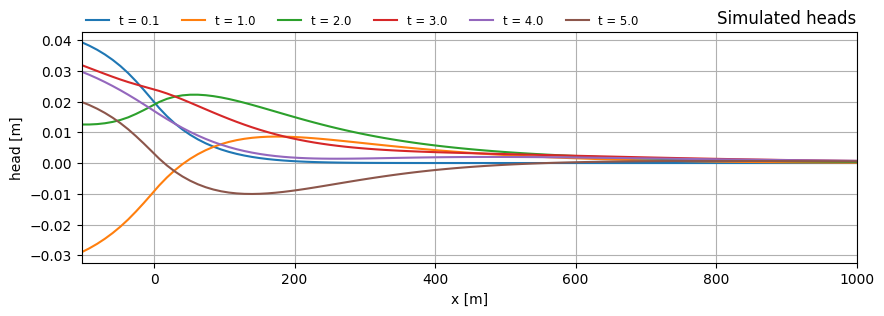

In [14]:
t = np.array([0.1, 1.0, 2.0, 3.0, 4.0, 5.0])
x = np.linspace(x0, 1000.0, 101)
y = np.zeros_like(x)

h = ml.headalongline(x, y, t)

f, ax = plt.subplots(1, 1, figsize=(10, 3))
for i in range(len(t)):
    ax.plot(x, h[0, i], label="t = {:.1f}".format(t[i]))
ax.legend(loc=(0, 1), frameon=False, ncol=8, fontsize="small")
ax.set_xlabel("x [m]")
ax.set_ylabel("head [m]")
ax.grid()
ax.set_title("Simulated heads", loc="right")
ax.set_xlim(x0, x.max());

Compare the model results to the observed heads in the two piezometers at $x = 1.0$ m and $x = 47.5$ m.

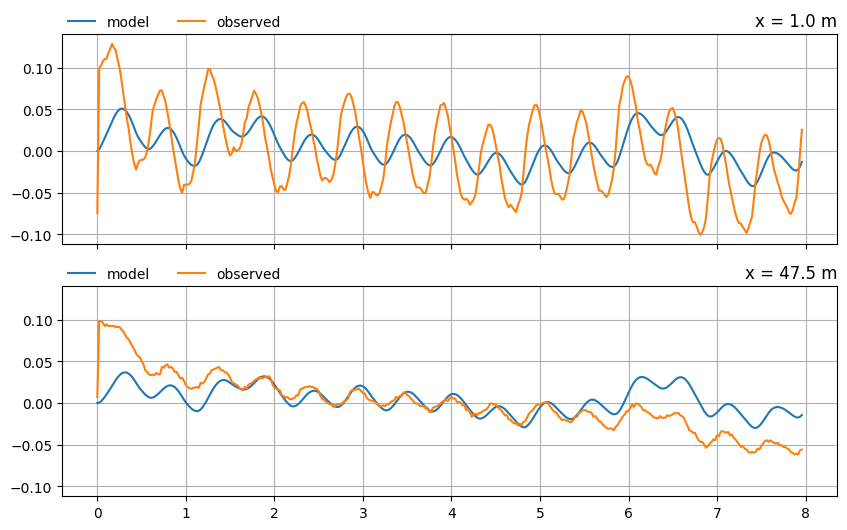

In [15]:
# piezometer locations in cross-section
xpb_kr = 1.0
xpb_bite = 47.5
xlocs = [xpb_kr, xpb_bite]

t = data_norm.index.to_numpy()

f, axes = plt.subplots(len(xlocs), 1, figsize=(10, 6), sharex=True, sharey=True)

for i in range(len(xlocs)):
    h = ml.head(xlocs[i], 0.0, t)
    axes[i].plot(t, h[0], label="model")
    hobs = data_norm.iloc[:, i + 1]
    axes[i].plot(hobs.index, hobs, label="observed")
    axes[i].set_title(f"x = {xlocs[i]} m", loc="right")
    axes[i].legend(loc=(0, 1), frameon=False, ncol=2)
    axes[i].grid()

## Calibrate model on observed heads

The model simulation is reasonable at the second observation well , but it clearly isn't as good at the river bank. Let's see if we can improve the fit of the model to the observations by calibrating the aquifer parameters.

Since the data at $t=0$ shows some jumps, we want to give the model some spin-up time before we start fitting to the data. We set a `tstart` value to select only observations after this moment. 

The following parameters will be calibrated:

- $k_h$ and $S_s$ of the aquifer, this parameter should be the same in each section.
- resistance $c$ of the confining units, this parameter can vary within each section. 
- specific storage ($S_s$) for the leaky layers of the river and foreland, and separately the specific storage of the leaky layer in the hinterland.

In total this means we have 7 parameters that can vary in this calibration step.

In [16]:
tstart = 2.0  # model spin-up time, calibrate on timeseries after 2 days

# create calibrate object
cal = ttim.Calibrate(ml)

# set observation time series
cal.series(
    "kruin",
    xpb_kr,
    0.0,
    layer=0,
    t=data_norm.loc[tstart:, "kruin"].index.to_numpy(),
    h=data_norm.loc[tstart:, "kruin"].values,
)
cal.series(
    "binnenteen",
    xpb_bite,
    0.0,
    layer=0,
    t=data_norm.loc[tstart:, "binnenteen"].index.to_numpy(),
    h=data_norm.loc[tstart:, "binnenteen"].values,
)

# define parameters for calibration
cal.set_parameter(
    "kaq",
    layers=0,
    initial=river.kaq[0],
    pmin=1.0,
    pmax=30.0,
    inhoms=(river, foreland, hinterland),
)
cal.set_parameter(
    "Saq",
    layers=0,
    initial=river.Saq[0],
    pmin=1e-6,
    pmax=1e-2,
    inhoms=(river, foreland, hinterland),
)
cal.set_parameter(
    "c",
    layers=0,
    initial=river.c[0],
    pmin=0.0,
    pmax=100.0,
    inhoms=river,
)
cal.set_parameter(
    "c",
    layers=0,
    initial=foreland.c[0],
    pmin=10.0,
    pmax=500.0,
    inhoms=(foreland),
)
cal.set_parameter(
    "c",
    layers=0,
    initial=hinterland.c[0],
    pmin=10.0,
    pmax=1000.0,
    inhoms=(hinterland),
)
cal.set_parameter(
    "Sll",
    layers=0,
    initial=river.Sll[0],
    pmin=1e-8,
    pmax=1e-4,
    inhoms=(river, foreland),
)
cal.set_parameter(
    "Sll",
    layers=0,
    initial=hinterland.Sll[0],
    pmin=1e-8,
    pmax=1e-1,
    inhoms=(hinterland),
)

# run the calibration
# cal.fit()
cal.fit_least_squares(report=False, method="trf")

# print the RMSE
print(f"RMSE: {cal.rmse():.5f}")

.............................................................................................................................................................................
RMSE: 0.01870


Show calibration parameters results

In [17]:
cal.parameters.iloc[:, :-2]

,layers,optimal,std,perc_std,pmin,pmax,initial
kaq_river_foreland_hinterland,0,3.239496,5.458589,168.501197,1.000000e+00,30.0000,10.000000
Saq_river_foreland_hinterland,0,0.000008,0.000034,446.041977,1.000000e-06,0.0100,0.000100
c_river,0,4.877666,81.420768,1669.256687,0.000000e+00,100.0000,100.000000
c_foreland,0,56.113189,1576.428587,2809.372650,1.000000e+01,500.0000,150.000000
c_hinterland,0,41.344577,76.666539,185.433118,1.000000e+01,1000.0000,500.000000
Sll_river_foreland,0,0.000020,0.000170,831.495666,1.000000e-08,0.0001,0.000001
Sll_hinterland,0,0.008009,0.014043,175.339276,1.000000e-08,0.1000,0.001000


Plot the locations of observation wells.

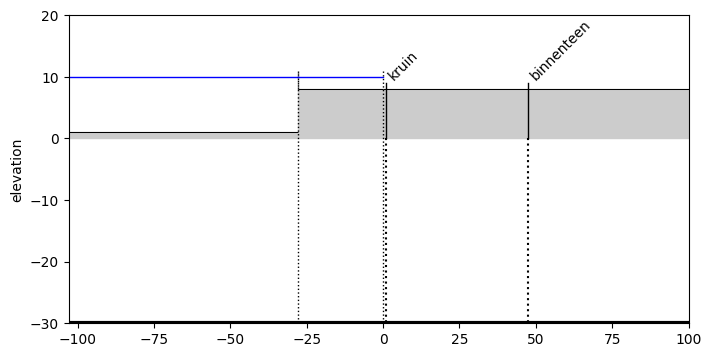

In [18]:
ax = river.plot(labels=False, params=False)
foreland.plot(ax=ax)
hinterland.plot(ax=ax, params=False)
ml.elementlist[0].plot(ax=ax, hstar=10.0)
ml.elementlist[1].plot(ax=ax, hstar=10.0)
ax.set_xlim(x0, 100.0)
ax.set_ylim(-30, 20)
cal.xsection(ax=ax);

Plot the modeled vs. observed time series for both observation wells after calibration.

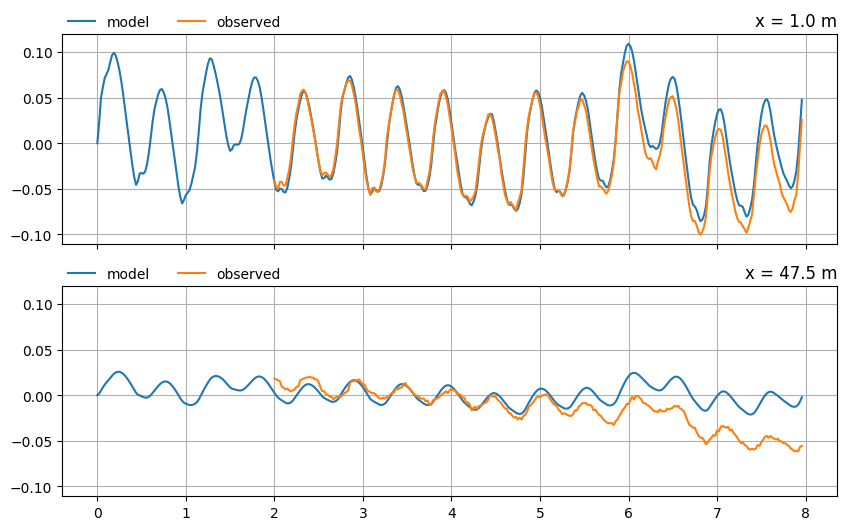

In [19]:
# piezometer locations in cross-section
xpb_kr = 1.0
xpb_bite = 47.5
xlocs = [xpb_kr, xpb_bite]

t = data_norm.index.to_numpy()

f, axes = plt.subplots(len(xlocs), 1, figsize=(10, 6), sharex=True, sharey=True)

for i in range(len(xlocs)):
    h = ml.head(xlocs[i], 0.0, t)
    axes[i].plot(t, h[0], label="model")
    hobs = data_norm.loc[tstart:].iloc[:, i + 1]  # showing calibration selection
    axes[i].plot(hobs.index, hobs, label="observed")
    axes[i].set_title(f"x = {xlocs[i]} m", loc="right")
    axes[i].legend(loc=(0, 1), frameon=False, ncol=2)
    axes[i].grid()

Let's take a look at the calibrated aquifer parameters.

In [20]:
(
    ml.aquifer_summary()
    .style.format(na_rep="-", precision=2)
    .format("{:.2e}", subset=["S_s"])
)

## Discussion

The calibration result shows that the specific storage of the leaky layer in the hinterland section is orders of magnitude higher than the other specific storage terms. Also the resistance of the confining unit is higher in the foreland than it is in the polder. 

These results have to be analyzed further to determine whether these results make physical sense. The fit to the observed data is reasonable, but from earlier testing it is clear that this problem is highly sensitive to the starting values of parameters, as well as the selected optimization method (`lmfit` through `cal.fit()` or with `scipy`'s least-squares through `cal.fit_least_squares(method="trf")`). Likely, there are many combinations of parameters that lead to similar fit results. Some other points that could influence the results:

- Only two piezometers in the cross-section. 
- The downwards trend in the head observations in the second piezometer probably isn't ideal as TTim will never be able to simulate that trend with the current input data.
- The time series are supposedly presented relative to a mean observed head/water level, but somehow do not fluctuate around 0.0, which mean they had to be normalized (again) for the TTim simulation.
- Neglecting the storage of the leaky layers yields a physically improbable solution where all resistance is put underneath the river section, and the foreland and hinterland have a resistance on the minimum parameter boundary. However, it is usually not expected that the storage in the leaky layers has such a large influence on the outcome. In many models this parameter is neglected altogether.

## Calibrate model using analytical formulas

Using normalized data.